In [1]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import joblib
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Flatten
from numpy import concatenate
from matplotlib import pyplot
from numpy import array
import math
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import SGD




In [2]:
# load dataset

df = pd.read_excel('datasetlimpio.xlsx', sheet_name='380033001951343334363036')
df = df.loc[:,['fecha','Bateria']]
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.resample('H', on='fecha').mean()
df = df.dropna()
values = df.values
values = values.astype('float32')

print (df.shape)

(3199, 1)


In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)
values = values.reshape((values.shape[0], values.shape[1], 1))

n_steps_out = 48
n_steps_in = 48

In [4]:
# split a univariate dataset into train/test sets
def split_dataset(X, y):
    train_X, test_X = X[:int((0.7*len(X))), :], X[int((0.7*len(X))):, :]
    train_Y, test_Y = y[:int((0.7*len(y))), :], y[int((0.7*len(y))):, :]
    return (train_X, test_X, train_Y, test_Y)


def to_supervised(train, n_steps_in, n_steps_out):
 # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
 # step over the entire history one time step at a time
    for in_start in range(len(data)):
 # define the end of the input sequence
        in_end = in_start + n_steps_in
        out_end = in_end + n_steps_out
 # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])                      
 # move along one time step
        in_start += 1
    return array(X), array(y)



In [5]:
x, y = to_supervised(values, n_steps_in, n_steps_out)
train_X, test_X, train_Y, test_Y = split_dataset(x, y)

print (x.shape)
print (y.shape)
print (test_X.shape)
print (test_Y.shape)

(3104, 48, 1)
(3104, 48)
(932, 48, 1)
(932, 48)


In [6]:
# train the model
def build_model(train_x, train_y, n_steps_in, n_steps_out):

 # define parameters
    verbose, epochs, batch_size = 0, 100, 16

 # define model
    model = Sequential()
    model.add(LSTM(200, activation='sigmoid', input_shape=(n_steps_in, 1)))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(n_steps_out))
    model.compile(loss='mse', optimizer='adam')
 # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

model = build_model(train_X, train_Y, n_steps_in, n_steps_out)

In [7]:
# prediccions

testPredict = model.predict(test_X)

testPredict = scaler.inverse_transform(testPredict)
test_YR = scaler.inverse_transform(test_Y)        

30/30 [==============================] - 1s 22ms/step


In [8]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculem RMSE per cada hora
    for i in range(actual.shape[1]):
        # calculem MSE
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculem RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calcul global de RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [9]:
RMSE_TOT, RMSE_horas = evaluate_forecasts(test_YR,testPredict)
print(RMSE_TOT)

17.46098751644042


[8.381397138494517, 12.802790838214547, 14.050215988942572, 14.525879488924511, 16.14307614646921, 16.897604037756267, 16.625366206904193, 16.926804885530302, 16.975950395948473, 16.88238770578491, 16.751025723607757, 17.303500594171688, 17.94580736420418, 17.54727675130015, 17.440792524896462, 16.96207461066176, 16.571347504215485, 16.63474899923585, 16.323385414090826, 15.530276354353072, 15.346397031729264, 15.763261812633603, 14.864194391299643, 13.20742348667029, 13.74575851218096, 16.56644815854756, 18.315326147109694, 19.551527754854046, 19.660420519657396, 19.054706718932497, 19.78721801017089, 19.4637615248264, 19.69941355805421, 20.14781345970404, 19.98968697726952, 20.71347250258233, 21.055712231556665, 20.79925060389421, 20.549367868024326, 19.620648527324793, 19.67242649023429, 19.195440482123207, 18.399761928179178, 17.606785662556, 18.237570514503414, 17.242576881647686, 16.720734950800516, 15.782037998581549]


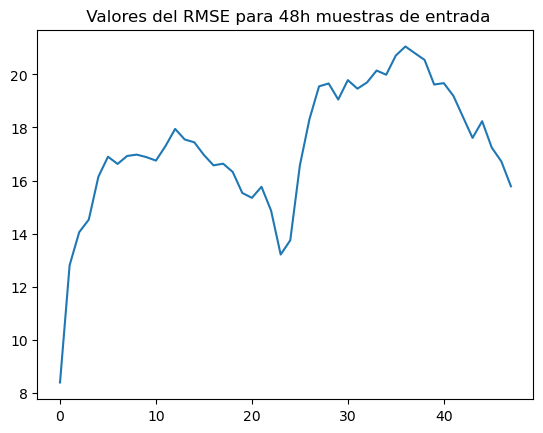

In [10]:
print(RMSE_horas)
plt.title(' Valores del RMSE para 48h muestras de entrada')
plt.plot (RMSE_horas)   

In [11]:
horas = list()
    
for i in range(test_YR.shape[1]):
    # calculem MSE
    horas.append((test_YR[:, i], testPredict[:, i]))

plt.figure(figsize=(15,8)) 
plt.plot(horas[0][0], label='real')
plt.plot(horas[0][1], label='predicció')
plt.legend(loc='lower left')
plt.title(' n_steps_in: 48 n_steps_out: 48 - RMSE: %.3f' %RMSE_TOT)

plt.show()


NameError: name 'dies' is not defined

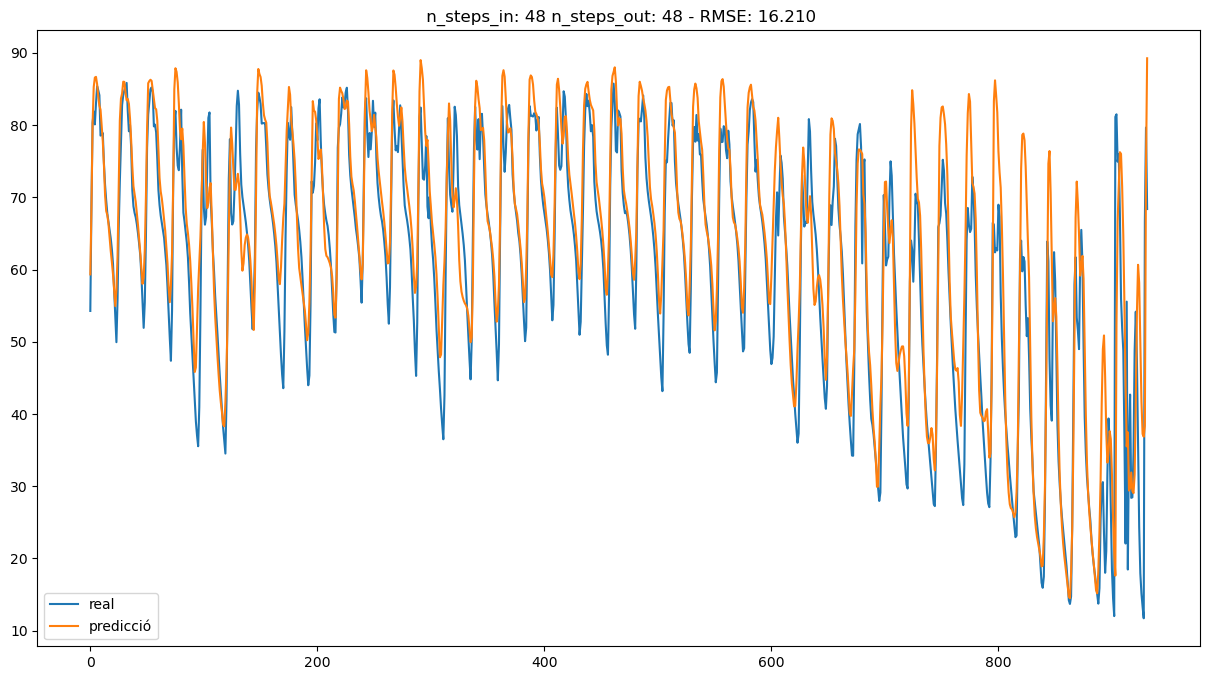